# PixelCNN on MNIST: Training and Sampling on CPU

In this notebook we implement a **small PixelCNN** for the MNIST dataset and run it entirely on **CPU**.

Goals:

1. Define a simple, masked-convolution-based **PixelCNN model** for MNIST digits (28×28, grayscale).
2. Keep **all configuration in one place**, so we can quickly switch between different model sizes and training settings.
3. Train the model for a **small number of epochs** (on a subset of MNIST if needed) and inspect the training loss.
4. Use the trained PixelCNN to **sample new digits from scratch**, one pixel at a time, to visualize how an autoregressive model generates images.
5. Write explanatory notes as a helpful and kind teacher. Never assume the student knows everything. 
6. Reuse what you can from the src/cvcourse repo. Data may already be downloaded in data dir, otherwise download again.

We intentionally keep the model and training setup **small and fast** so everything runs on CPU during a live class.
We focus only on **unconditional sampling** (no inpainting, no conditioning on labels) to keep the demo simple and clear.


## Notebook Roadmap

1. Get our imports, CPU-only config, and seeding in order.
2. Build lightweight dataloaders that optionally subset MNIST for speed.
3. Implement masked convolutions and a compact PixelCNN stack.
4. Train for a handful of epochs while logging losses.
5. Sample digits one pixel at a time and visualize the grid.
6. Capture next steps and tips for further exploration.

## 1. Imports and deterministic setup

We keep the runtime lightweight: only PyTorch, TorchVision, Matplotlib, and a couple of utility helpers from `cvcourse`. Everything stays on CPU and we seed all RNGs for reproducibility.

In [25]:
from __future__ import annotations

import random
import sys
from dataclasses import dataclass
from pathlib import Path
from math import ceil

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

PROJECT_ROOT = Path.cwd().resolve().parents[1]
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from cvcourse.utils.device import get_device
from cvcourse.utils.paths import get_data_dir

plt.rcParams["figure.dpi"] = 120


def set_seed(seed: int) -> None:
    """Seed Python and PyTorch RNGs for replicable CPU demos."""

    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

## 2. Configuration & experiment hyper-parameters

Centralising hyper-parameters in a dataclass makes it easy to tweak model size, training length, or sampling grid without editing many cells. We keep the default run tiny so it finishes within a couple of minutes on CPU.

In [26]:
@dataclass
class PixelCNNConfig:
    data_root: Path = get_data_dir() / "MNIST"
    batch_size: int = 128
    num_workers: int = 2
    epochs: int = 3
    lr: float = 1e-3
    subset_train: int | None = 20000  # None = use full 60k examples
    subset_val: int | None = 2000
    log_every: int = 150
    hidden_channels: int = 64
    residual_blocks: int = 5
    kernel_size: int = 7
    device: torch.device = get_device(allow_gpu=False)
    seed: int = 7
    sample_rows: int = 6
    sample_cols: int = 6


cfg = PixelCNNConfig()
set_seed(cfg.seed)
cfg

PixelCNNConfig(data_root=PosixPath('/Users/mishra/LM/projects/computer-vision-cas-hslu-2025/data/MNIST'), batch_size=128, num_workers=2, epochs=3, lr=0.001, subset_train=20000, subset_val=2000, log_every=150, hidden_channels=64, residual_blocks=5, kernel_size=7, device=device(type='cpu'), seed=7, sample_rows=6, sample_cols=6)

## 3. MNIST dataset + dataloaders

PixelCNN treats each pixel as a Bernoulli variable. We therefore only need the raw grayscale images in `[0, 1]`. To keep CPU runs brief we optionally sample a subset of the 60k training digits.

In [4]:
def build_dataloaders(cfg: PixelCNNConfig) -> tuple[DataLoader, DataLoader]:
    transform = transforms.ToTensor()
    train_set = datasets.MNIST(root=cfg.data_root, train=True, download=True, transform=transform)
    val_set = datasets.MNIST(root=cfg.data_root, train=False, download=True, transform=transform)

    if cfg.subset_train and cfg.subset_train < len(train_set):
        generator = torch.Generator().manual_seed(cfg.seed)
        subset_idx = torch.randperm(len(train_set), generator=generator)[: cfg.subset_train]
        train_set = Subset(train_set, subset_idx.tolist())

    if cfg.subset_val and cfg.subset_val < len(val_set):
        val_set = Subset(val_set, list(range(cfg.subset_val)))

    common = dict(batch_size=cfg.batch_size, num_workers=cfg.num_workers, pin_memory=False)
    train_loader = DataLoader(train_set, shuffle=True, **common)
    val_loader = DataLoader(val_set, shuffle=False, **common)
    return train_loader, val_loader


train_loader, val_loader = build_dataloaders(cfg)
len(train_loader), len(val_loader)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.18MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 174kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.70MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.25MB/s]


(157, 16)

## 4. Masked convolutions and PixelCNN model

Masked convolutions ensure that the prediction for pixel `(i, j)` only sees pixels above or to the left. The first layer uses a type-"A" mask that blocks the current pixel, later layers use type-"B" masks that can access it (via previous activations) without leaking future information.

In [5]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, mask_type: str, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        if mask_type not in {"A", "B"}:
            raise ValueError("mask_type must be 'A' or 'B'")
        self.mask_type = mask_type
        self.register_buffer("mask", torch.ones_like(self.weight))
        self._build_mask()

    def _build_mask(self) -> None:
        k_h, k_w = self.kernel_size if isinstance(self.kernel_size, tuple) else (self.kernel_size, self.kernel_size)
        yc, xc = k_h // 2, k_w // 2
        self.mask[:, :, yc + 1 :, :] = 0
        self.mask[:, :, yc, xc + (1 if self.mask_type == "B" else 0) :] = 0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.conv2d(x, self.weight * self.mask, self.bias, self.stride, self.padding, self.dilation, self.groups)


class SimplePixelCNN(nn.Module):
    def __init__(self, cfg: PixelCNNConfig):
        super().__init__()
        padding = cfg.kernel_size // 2
        layers: list[nn.Module] = [
            MaskedConv2d(1, cfg.hidden_channels, cfg.kernel_size, mask_type="A", padding=padding),
            nn.ReLU(),
        ]

        for _ in range(cfg.residual_blocks):
            layers += [
                MaskedConv2d(cfg.hidden_channels, cfg.hidden_channels, 3, mask_type="B", padding=1),
                nn.ReLU(),
            ]

        layers.append(MaskedConv2d(cfg.hidden_channels, 1, 1, mask_type="B"))
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


model = SimplePixelCNN(cfg).to(cfg.device)
print(f"Model parameters: {count_parameters(model)/1e6:.2f}M")

Model parameters: 0.19M


## 5. Training utilities (losses, loops, logging)

We optimise Binary Cross Entropy with logits, since each pixel is treated as a Bernoulli variable. The helper below runs a tiny number of epochs and keeps history for plotting.

In [6]:
def run_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer | None,
    device: torch.device,
    criterion: nn.Module,
    log_every: int,
    train: bool = True,
) -> float:
    model.train(train)
    running_loss = 0.0
    for step, (images, _) in enumerate(loader, start=1):
        images = images.to(device)
        logits = model(images)
        loss = criterion(logits, images)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        running_loss += loss.item()
        if train and step % log_every == 0:
            print(f"step {step:04d} | loss={loss.item():.4f}")

    return running_loss / len(loader)


def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, cfg: PixelCNNConfig):
    history = {"train": [], "val": []}
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(1, cfg.epochs + 1):
        train_loss = run_epoch(model, train_loader, optimizer, cfg.device, criterion, cfg.log_every, train=True)
        val_loss = run_epoch(model, val_loader, None, cfg.device, criterion, cfg.log_every, train=False)
        history["train"].append(train_loss)
        history["val"].append(val_loss)
        print(f"Epoch {epoch}/{cfg.epochs} | train={train_loss:.4f} | val={val_loss:.4f}")

    return history


history = train_model(model, train_loader, val_loader, cfg)
history

step 0150 | loss=0.0991
Epoch 1/3 | train=0.2276 | val=0.0948
step 0150 | loss=0.0862
Epoch 2/3 | train=0.0897 | val=0.0852
step 0150 | loss=0.0840
Epoch 3/3 | train=0.0857 | val=0.0828


{'train': [0.22764416205085766, 0.08973456729369558, 0.08574722047634185],
 'val': [0.09484499972313643, 0.08522491669282317, 0.08282006019726396]}

## 6. Visualise the learning curves

A quick plot helps sanity-check whether the model underfits, overfits, or diverges. Expect relatively noisy curves because we limit the dataset and epochs for speed.

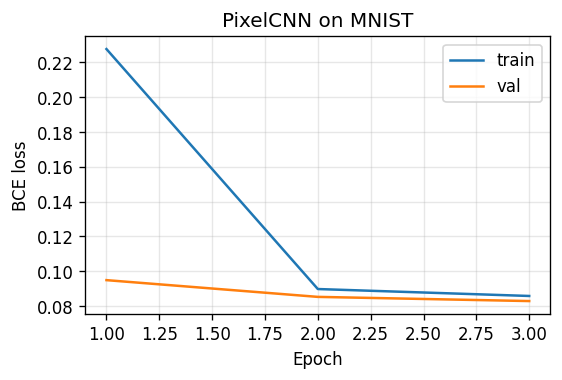

In [7]:
def plot_history(history: dict[str, list[float]]) -> None:
    if not history["train"]:
        print("History is empty. Run the training cell first.")
        return
    epochs = range(1, len(history["train"]) + 1)
    plt.figure(figsize=(5, 3))
    plt.plot(epochs, history["train"], label="train")
    plt.plot(epochs, history["val"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("BCE loss")
    plt.title("PixelCNN on MNIST")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


plot_history(history)

## 7. Autoregressive sampling

To draw new digits we start with an all-zero canvas and let PixelCNN fill in pixels row-by-row. Each prediction only depends on previously generated pixels thanks to the masks.

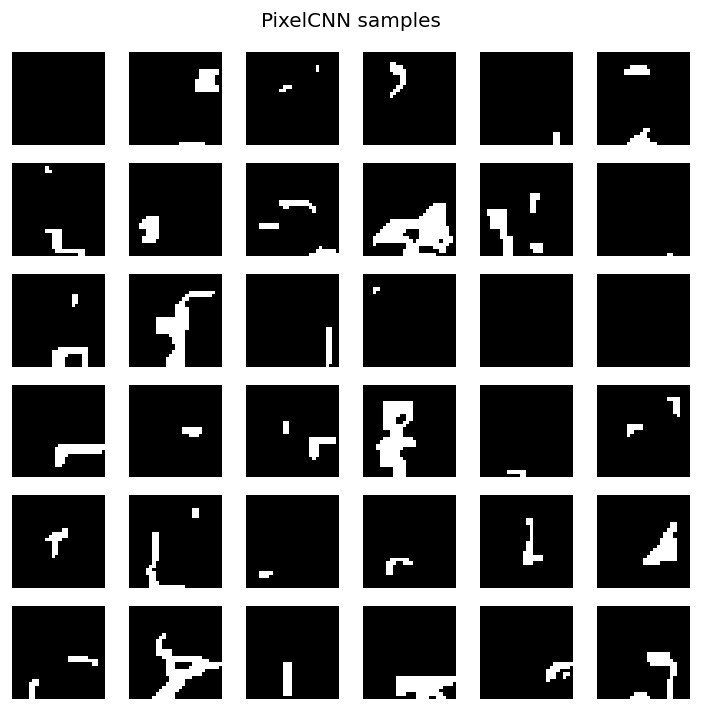

In [8]:
def sample_digits(model: nn.Module, n_samples: int, cfg: PixelCNNConfig) -> torch.Tensor:
    model.eval()
    samples = torch.zeros(n_samples, 1, 28, 28, device=cfg.device)
    with torch.no_grad():
        for row in range(28):
            for col in range(28):
                logits = model(samples)
                probs = torch.sigmoid(logits[:, :, row, col])
                samples[:, :, row, col] = torch.bernoulli(probs)
    return samples.cpu()


def show_samples(samples: torch.Tensor, rows: int, cols: int) -> None:
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
    for ax, img in zip(axes.flatten(), samples):
        ax.imshow(img.squeeze(0), cmap="gray")
        ax.axis("off")
    plt.suptitle("PixelCNN samples")
    plt.tight_layout()
    plt.show()


n_samples = cfg.sample_rows * cfg.sample_cols
samples = sample_digits(model, n_samples, cfg)
show_samples(samples, cfg.sample_rows, cfg.sample_cols)

### Let's see the output at every timestep

The next cell samples **one** digit and stores the canvas after each of the 784 pixel updates. Unpainted pixels stay visible thanks to a calm blue-grey background, so you can literally watch the digit grow row by row via a multi-row grid.

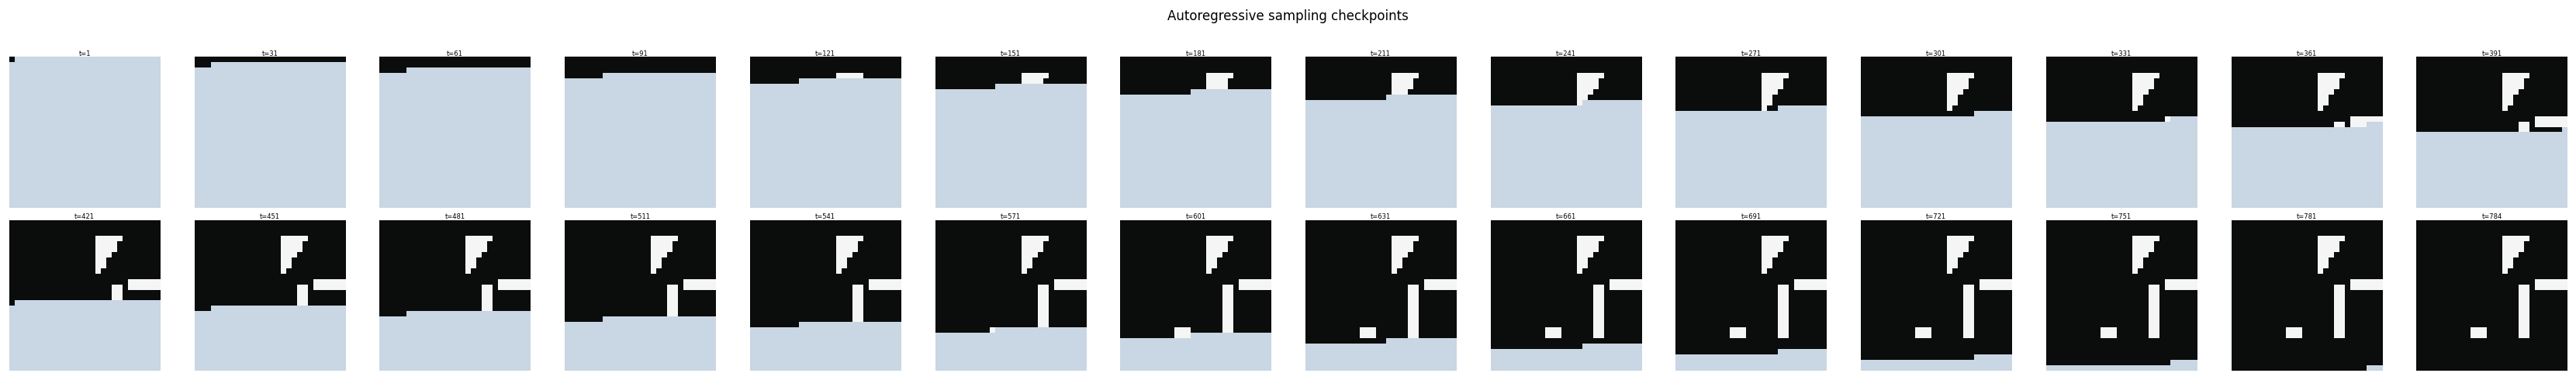

In [31]:
def sample_with_history(model: nn.Module, cfg: PixelCNNConfig) -> list[torch.Tensor]:
    """Sample a single digit and capture the full sequence of canvases."""

    model.eval()
    samples = torch.zeros(1, 1, 28, 28, device=cfg.device)
    filled = torch.zeros_like(samples, dtype=torch.bool)
    history: list[torch.Tensor] = []
    with torch.no_grad():
        for row in range(28):
            for col in range(28):
                logits = model(samples)
                probs = torch.sigmoid(logits[:, :, row, col])
                samples[:, :, row, col] = torch.bernoulli(probs)
                filled[:, :, row, col] = True
                display = samples.clone()
                display[~filled] = -1.0  # mark untouched pixels for coloring
                history.append(display.cpu())
    return history


BG_CMAP = ListedColormap(["#c9d6e3", "#0b0c0c", "#f5f5f5"])
BG_NORM = BoundaryNorm([-1.5, -0.5, 0.5, 1.5], BG_CMAP.N)
PLOT_EVERY_N_FRAME = 30


def plot_generation_grid(history: list[torch.Tensor], cols: int = 14, plot_every_N_frame: int = PLOT_EVERY_N_FRAME) -> None:
    """Show timesteps on a multi-row grid using a blue-grey background."""

    if not history:
        print("History is empty. Run sample_with_history first.")
        return

    indices = list(range(0, len(history), max(1, plot_every_N_frame)))
    if indices[-1] != len(history) - 1:
        indices.append(len(history) - 1)

    rows = ceil(len(indices) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()
    for ax in axes:
        ax.axis("off")

    for ax, idx in zip(axes, indices):
        ax.imshow(history[idx][0, 0], cmap=BG_CMAP, norm=BG_NORM, interpolation="nearest")
        ax.set_title(f"t={idx + 1}", fontsize=5, pad=1)
        ax.axis("off")

    plt.suptitle("Autoregressive sampling checkpoints", y=1.01, fontsize=10)
    plt.tight_layout()
    plt.show()


history_frames = sample_with_history(model, cfg)
plot_generation_grid(history_frames, cols=14, plot_every_N_frame=PLOT_EVERY_N_FRAME)

## 8. Where to go next

- Increase `residual_blocks`, widen `hidden_channels`, or switch to 256-way logits (one-hot over gray levels) for higher fidelity.
- Move training to GPU by setting `get_device(allow_gpu=True)` if available.
- Add conditioning on class labels or previous latent codes (conditional PixelCNN).
- Swap MNIST for FashionMNIST or CIFAR-10 (just mind the extra channels).
- Log samples to Weights & Biases or TensorBoard for live monitoring during training.